На основании имеющихся данных о пассажирах "Титаника" построим модель для прогноза, выживет или погибнет пассажир при аварии в зависимости от указанных параметров. Прогноз выполним для тестового датасета.

### Подключение библиотек и скриптов

In [1]:
# Подключаем требуемые библиотеки.
import numpy as np
import pandas as pd
import re


from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Игнорируем предупреждения.
import warnings
warnings.simplefilter('ignore')

### Необходимые функции

In [3]:
def visualization(feature, target, data, palette):
    """
    визуализация для корелляции значений признаков с таргетом
    """
    plt.figure(figsize=(10, 8))

    sns.countplot(x=feature, hue=target, data=data, palette=palette)
    plt.title(f'{feature} grouped by target variable')
    plt.legend(['dead', 'alive'], loc='upper right')

    plt.show()
    
def visualization_many_values(size, feature, target, data, palette):
    """
    визуализация для корелляции значений признаков с таргетом с задаваемым размером (для 
    большого количества признаков)
    """
    plt.figure(figsize=(10, size))
    
    sns.countplot(data=data, y=feature, hue=target, palette=palette)
    plt.title(f'{feature} grouped by target variable')
    plt.legend(['dead', 'alive'], loc='upper right')

    plt.show()
    
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """
    отчет о метриках модели
    """
    print(f'TRAIN\n{classification_report(y_train_true, y_train_pred)}')
    print(f'TEST\n{classification_report(y_test_true, y_test_pred)}')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def drop_pass_id(df):
    """
    выбрасывает из датафрейма признак PassengerId
    """
    df = df.drop(['PassengerId'], axis=1)
    return df

def title_from_name(df):
    """
    добавляет в датафрейм признак Title, который содержится в признаке Name, а Name выбрасывает
    """
    df['Title'] = df.Name.str.extract(' (\w+)\.')
    df = df.drop(['Name'], axis=1)
    return df

def make_title_a_frequency(df):
    """
    меняет значение Title на частоту встречающегося титула
    """
    title = df['Title'].value_counts()
    frequency = {i: title[i] for i in title.index.unique()}
    df['Title'] = df['Title'].map(frequency).fillna(np.nan)
    return df

def make_sex_a_num(df):
    """
    меняет категориальное значение признака Sex на числовое
    """
    df['Sex'] = df['Sex'].replace(['male', 'female'], [0, 1])
    return df

def fulfill_missing_values(df, col):
    """
    заполняет пропущенные значения в датафрейме медианными
    """
    df[col] = df[col].fillna(df[col].median())
    return df

def create_a_family(df):
    """
    считает количество человек в семье, используя значения SibSp + Parch + сам пассажир
    """
    df['Family'] = df['SibSp'] + df['Parch'] + 1
    return df

def make_tickets_into_persons(df):
    """
    указывает в признаке Ticket, сколько человек едет по этому билету
    """
    ticket = df['Ticket'].value_counts()
    persons_for_one_ticket = {j: ticket[j] for j in ticket.index}
    df['Ticket'] = df['Ticket'].map(persons_for_one_ticket).fillna(np.nan)
    return df

def cabin_2b_or_not_2b(df):
    """
    использует два значения: есть каюта или нет каюты
    """
    df['Cabin'] = df['Cabin'].fillna(0)
    df.loc[df['Cabin'] != 0, 'Cabin'] = 1
    df['Cabin'] = df['Cabin'].astype('int64')
    return df

def port_number(df):
    """
    заменяет буквенное обозначение порта числовым
    """
    df['Embarked'] = df['Embarked'].replace(['S', 'C', 'Q'], [1, 2, 3])
    return df

def normalize(df, features):
    """
    нормализует данные в переданном датафрейме
    """
    scaler = MinMaxScaler()

    norm = scaler.fit_transform(df)

    norm_df = pd.DataFrame(norm, columns=features)
    return norm_df

### Пути к директориям и файлам

In [4]:
DATASET_PATH = 'titanic_train.csv'
TEST_DATASET_PATH = 'titanic_test.csv'
RESULT_PATH = 'titanic.csv'

### Описание датасета

PassengerId - уникальный ID пассажира

Survived - выжил ли пассажир/таргет (нет - 0, да - 1)

Pclass - пассажирский класс (1, 2, 3)

Name - имя пассажира

Sex - пол (мужской - male, женский - female)

Age - возраст

SibSp - количество братьев, сестер и супругов на борту

Parch - количество родителей и детей на борту

Ticket - номер билета

Fare - плата за проезд, которую заплатил пассажир (0 зачастую для персонала Титаника)

Cabin - каюта

Embarked - порт посадки (C - Шербур; Q - Квинстаун; S - Саутгемптон)

### Загрузка данных

In [5]:
titanic = pd.read_csv(DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
titanic.shape

(891, 12)

In [8]:
test.shape

(418, 11)

### Обзор датасета

In [9]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### Выделение целевой переменной и групп признаков

In [11]:
target = 'Survived'
features = titanic.columns.to_list()
features.remove(target)
features

['PassengerId',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [12]:
# Посмотрим, какие значения принимает таргет. Погибла большая часть пассажиров(
titanic[target].value_counts()

0    549
1    342
Name: Survived, dtype: int64

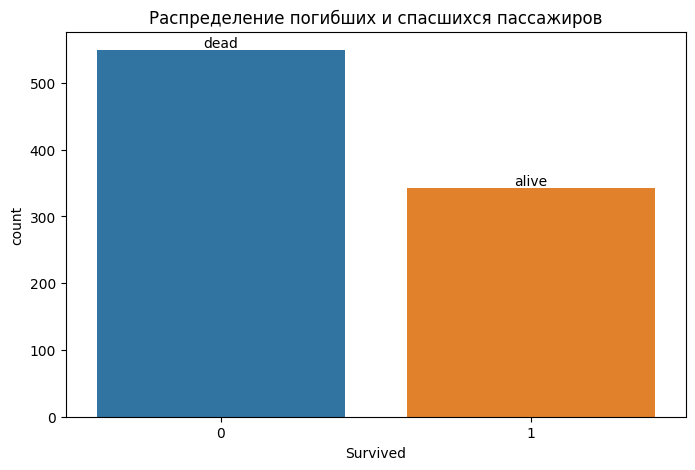

In [13]:
# Отобразим значения таргета на графике.
plt.figure(figsize=(8, 5))

gr = sns.countplot(x=target, data=titanic)

gr.bar_label(container=gr.containers[0], labels=['dead', 'alive'])
plt.title('Распределение погибших и спасшихся пассажиров')

plt.show()

In [14]:
# Признаки PassengerId не влияет на таргет Survived. Выбросим его из датасетов (но сохраним для 
# тестового).
titanic = drop_pass_id(titanic)
pass_id = test['PassengerId']
test = drop_pass_id(test)

In [15]:
# Посмотрим, какие значения принимает Pclass.
titanic['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

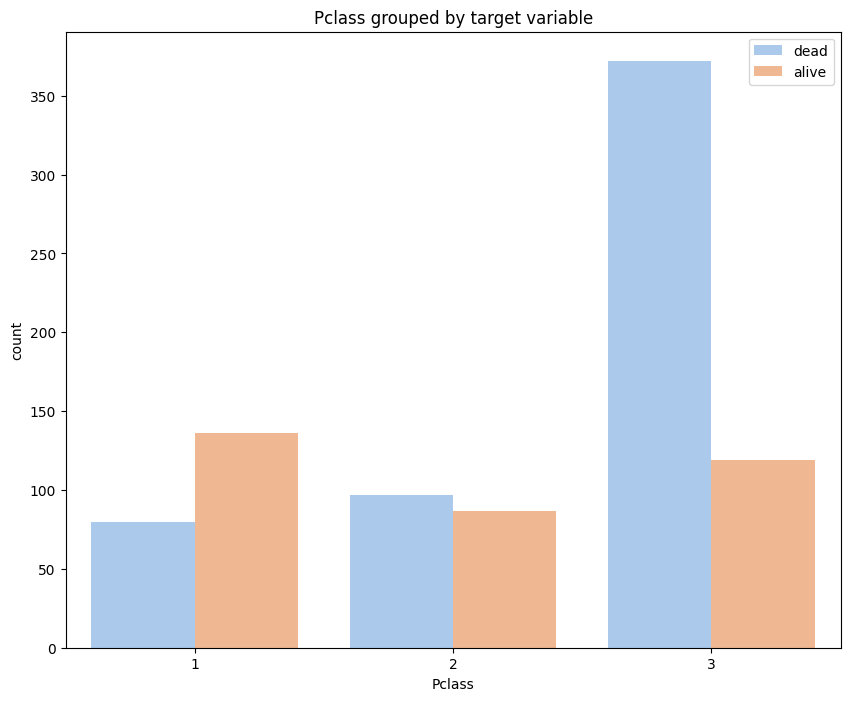

In [16]:
# Визуализируем корреляцию признака Pclass и таргета.
visualization('Pclass', target, titanic, 'pastel')

Пассажиры первого класса чаще выживали, пассажиры второго класса примерно поровну, пассажиры третьего класса большей частью погибли(

In [17]:
# Из признака имени возьмем только титул пассажира. Создадим новый признак, а Name удалим.
titanic = title_from_name(titanic)
test = title_from_name(test)
titanic['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

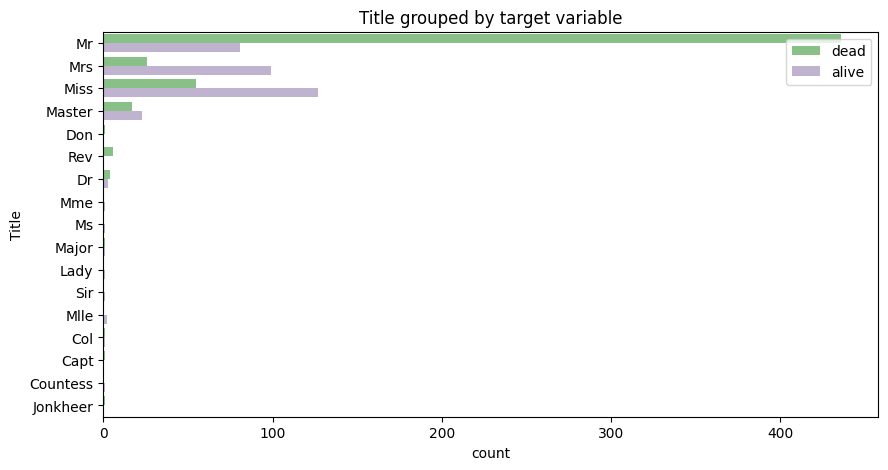

In [18]:
# Смотрим частоту встречающихся титулов в корреляции с таргетом.
visualization_many_values(5, feature='Title', target=target, data=titanic, palette='Accent')

In [19]:
# Превращаем категориальное значение Title в числовое.
titanic = make_title_a_frequency(titanic)
test = make_title_a_frequency(test)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,517
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,125
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,182
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,125
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,517


In [20]:
# Посмотрим, какие значения принимает Sex.
titanic['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [21]:
# Заменяем значения пола на 0 для мужского и 1 для женского.
titanic = make_sex_a_num(titanic)
test = make_sex_a_num(test)
titanic['Sex'].value_counts()

0    577
1    314
Name: Sex, dtype: int64

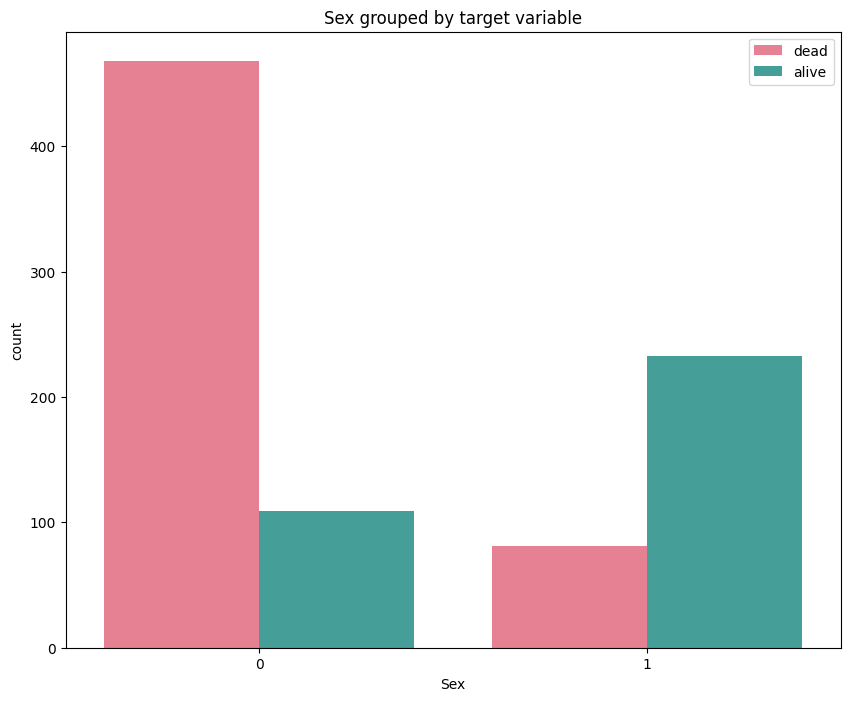

In [22]:
# Визуализируем корреляцию признака Sex и таргета.
visualization('Sex', target, titanic, 'husl')

Мужчины чаще погибали, чем выживали, женщины чаще выживали, чем погибали.

In [23]:
# Пропущенные значения возраста мы меняем на медиану (мы было хотели поставить рандомную 
# величину, но модель учтет это, поэтому все пропущенные признаки будут принимать одинаковые
# значения).
titanic = fulfill_missing_values(titanic, 'Age')
test = fulfill_missing_values(test, 'Age')

# Посмотрим, какие значения принимает Age.
titanic['Age'].value_counts()

28.00    202
24.00     30
22.00     27
18.00     26
19.00     25
        ... 
36.50      1
55.50      1
0.92       1
23.50      1
74.00      1
Name: Age, Length: 88, dtype: int64

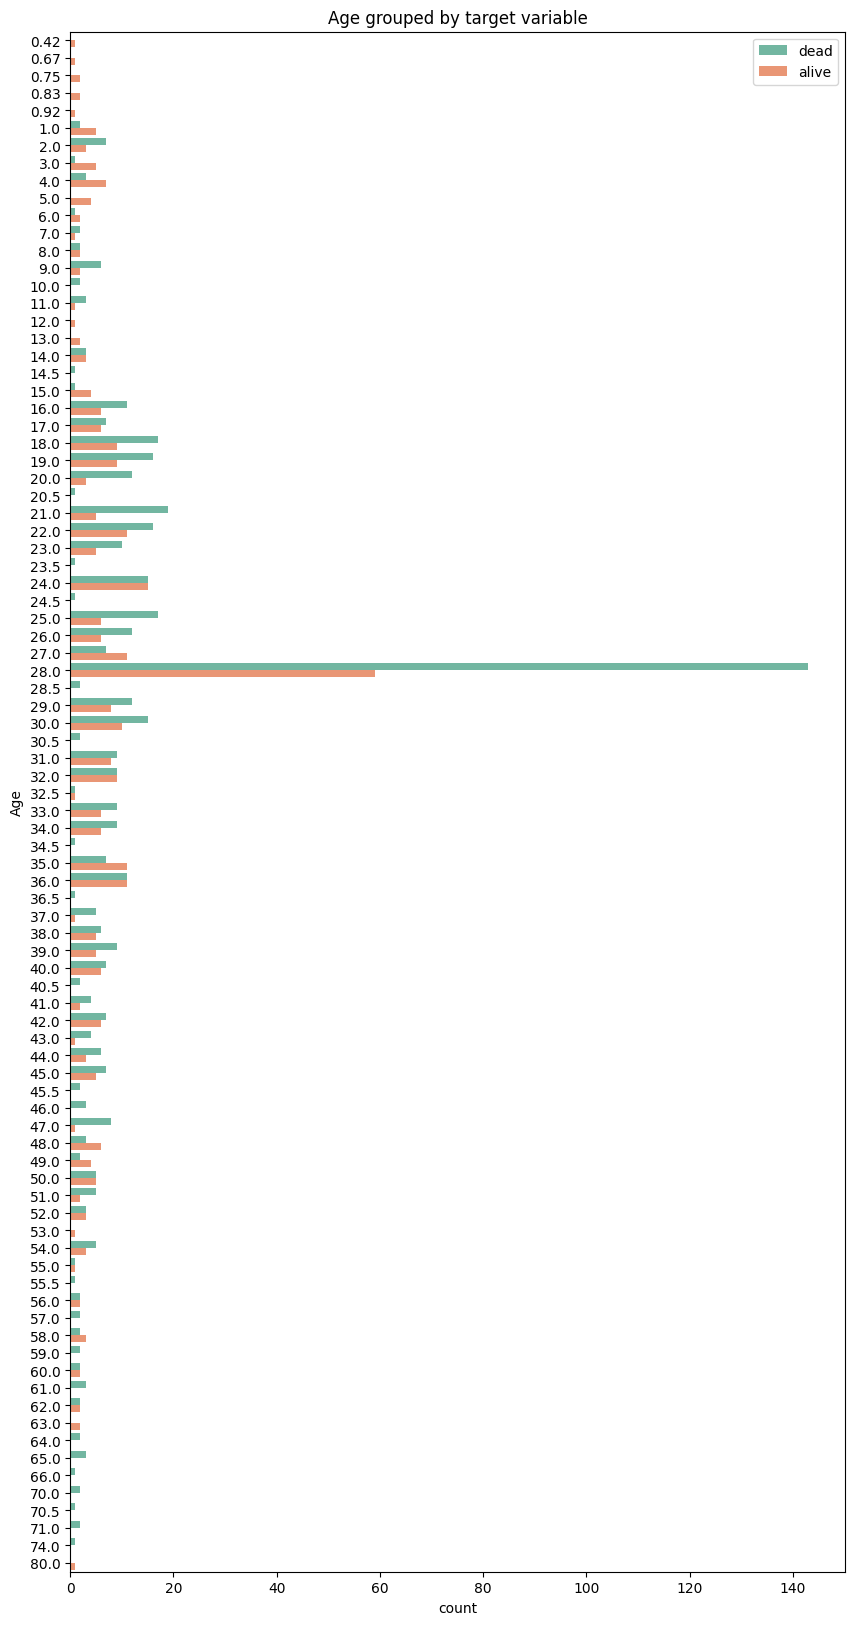

In [24]:
# Визуализируем корреляцию признака Age и таргета.
visualization_many_values(20, 'Age', target, titanic, 'Set2')

In [25]:
# Посмотрим, какие значения принимает SibSp.
titanic['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

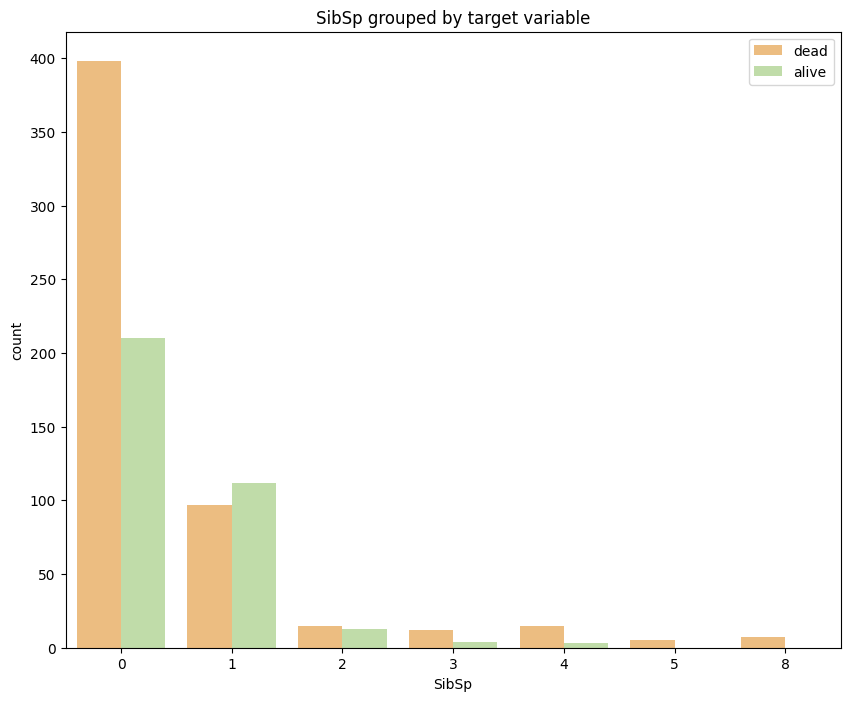

In [26]:
# Визуализируем корреляцию признака SibSp и таргета.
visualization('SibSp', target, titanic, 'Spectral')

In [27]:
# Посмотрим, какие значения принимает Parch.
titanic['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

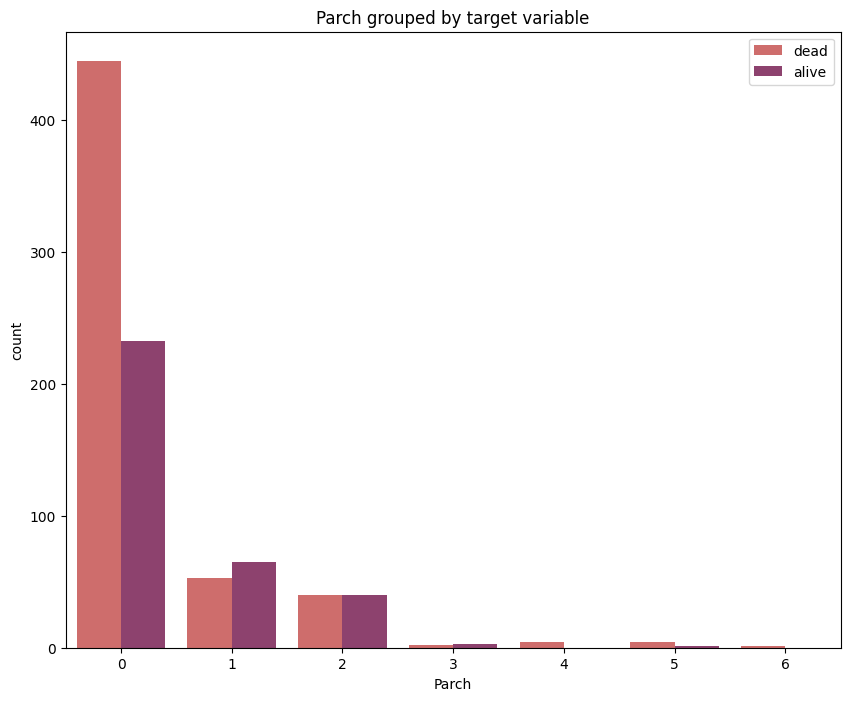

In [28]:
# Визуализируем корреляцию признака Parch и таргета.
visualization('Parch', target, titanic, 'flare')

In [29]:
# Создадим новую переменную Family, в котором объединим значения признаков SibSp и Parch.
titanic = create_a_family(titanic)
test = create_a_family(test)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,517,2
1,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,125,2
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,182,1
3,1,1,1,35.0,1,0,113803,53.1000,C123,S,125,2
4,0,3,0,35.0,0,0,373450,8.0500,NaN,S,517,1


In [30]:
# Посмотрим, сколько уникальных билетов куплено.
titanic['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [31]:
# Заменяем значение в поле Ticket количеством человек, едущим по этому билету.
titanic = make_tickets_into_persons(titanic)
test = make_tickets_into_persons(test)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,0,3,0,22.0,1,0,1,7.2500,NaN,S,517,2
1,1,1,1,38.0,1,0,1,71.2833,C85,C,125,2
2,1,3,1,26.0,0,0,1,7.9250,NaN,S,182,1
3,1,1,1,35.0,1,0,2,53.1000,C123,S,125,2
4,0,3,0,35.0,0,0,1,8.0500,NaN,S,517,1


In [32]:
# Посмотрим, какие значения принимает Fare.
test = fulfill_missing_values(test, 'Fare')
titanic['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

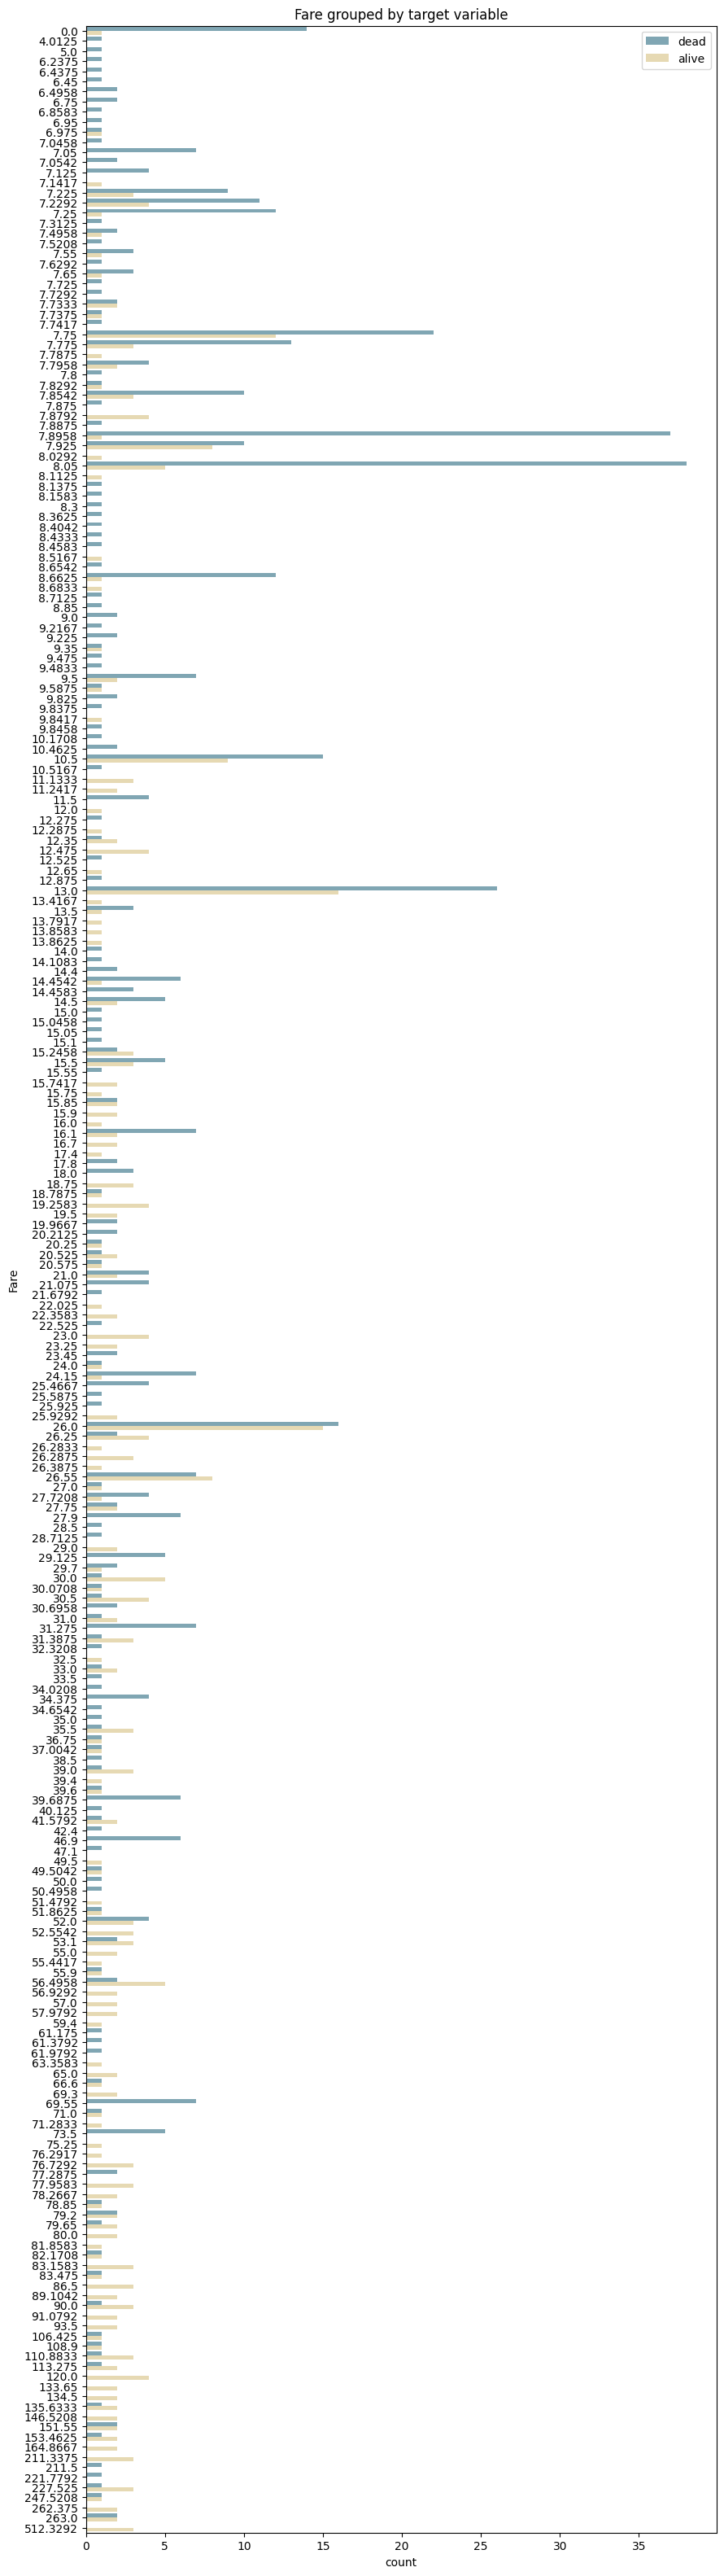

In [33]:
# Визуализируем корреляцию признака Fare и таргета.
visualization_many_values(40, 'Fare', target, titanic, 'blend:#7AB,#EDA')

In [34]:
# Параметр "Каюта" делаем бинарным - он либо есть, либо его нет.
titanic = cabin_2b_or_not_2b(titanic)
test = cabin_2b_or_not_2b(test)
titanic['Cabin'].value_counts()

0    687
1    204
Name: Cabin, dtype: int64

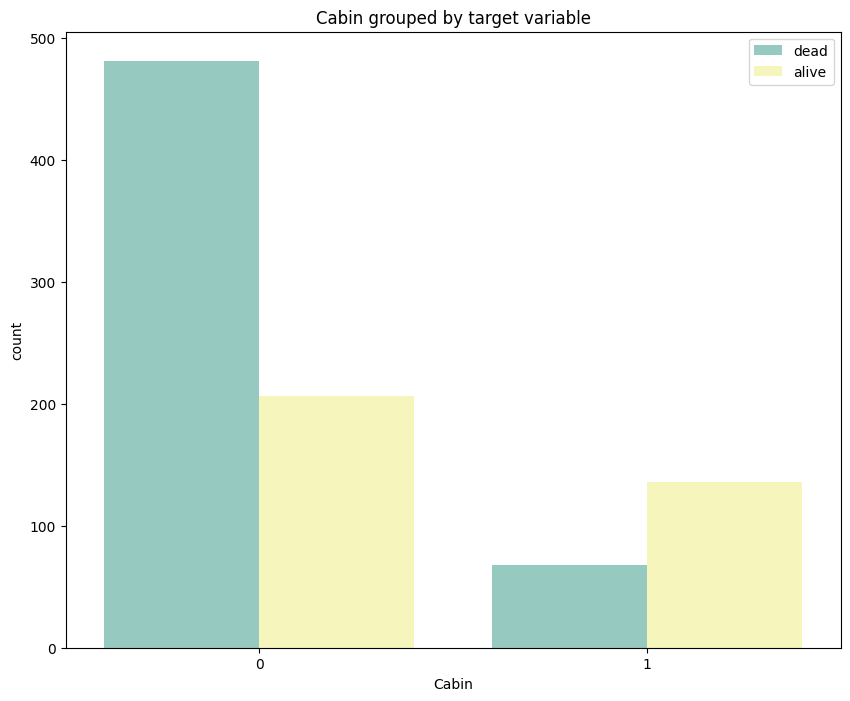

In [35]:
# Визуализируем корреляцию признака Cabin и таргета.
visualization('Cabin', target, titanic, 'Set3')

In [36]:
# Cмотрим, какой порт посадки использовался чаще всего.
titanic['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [37]:
# Заменяем два пропущенных значения порта и заменяем их числовыми значениями 
# (S - 1, C - 2, Q - 3))
titanic['Embarked'] = titanic['Embarked'].fillna('S')
titanic = port_number(titanic)
test = port_number(test)
titanic['Embarked'].value_counts()

1    646
2    168
3     77
Name: Embarked, dtype: int64

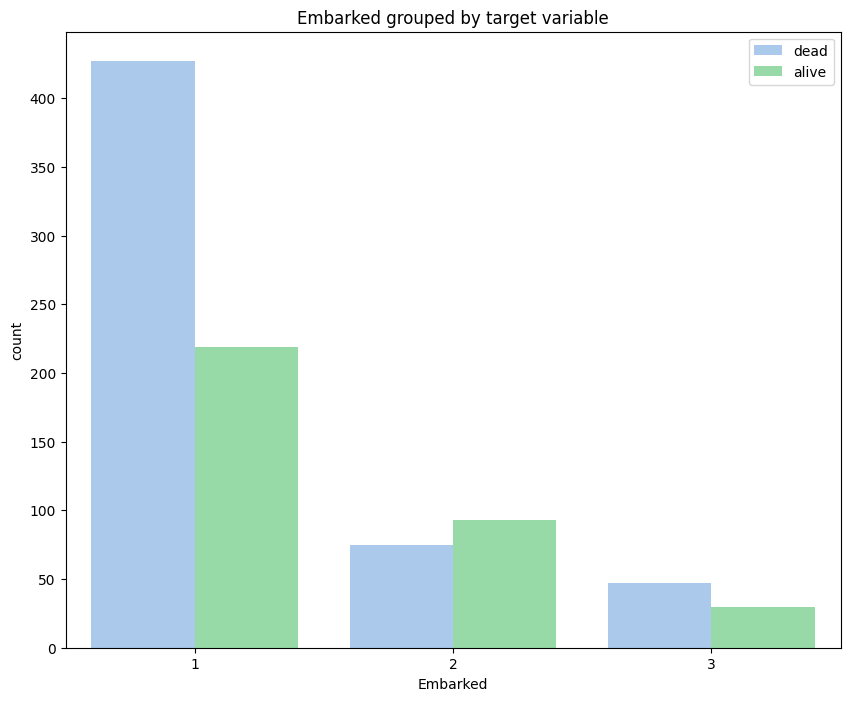

In [38]:
# Визуализируем корреляцию признака Embarked и таргета.
visualization('Embarked', target, titanic, 'pastel6')

In [39]:
# Проверяем датасет - все признаки приведены к числовому типу, пропуски заполнены. Мы 
# просмотрели значения значимых признаков, выбросов нет. 
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     891 non-null    int64  
 9   Embarked  891 non-null    int64  
 10  Title     891 non-null    int64  
 11  Family    891 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 83.7 KB


### Корреляция со значимыми признаками

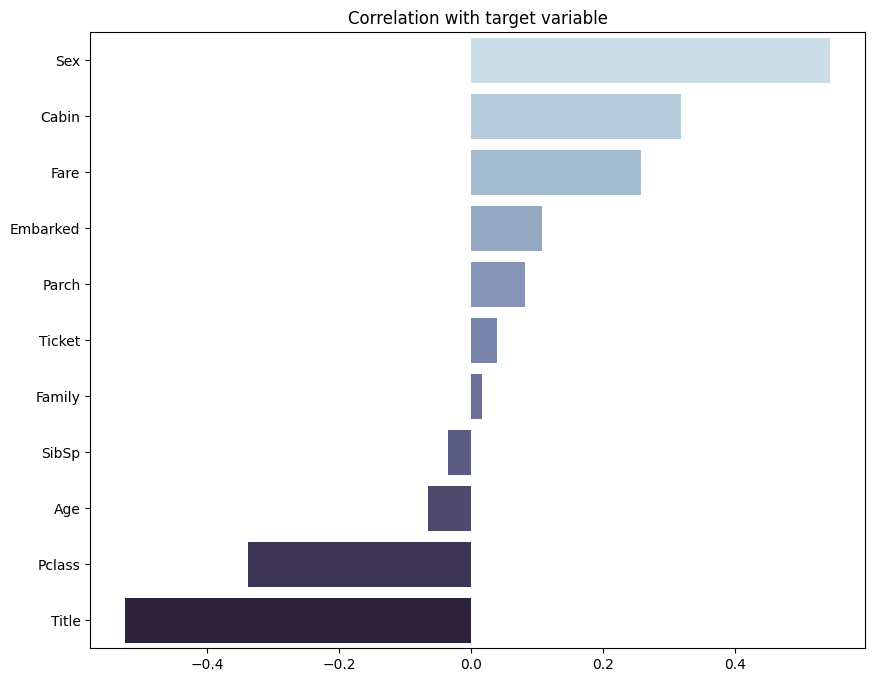

In [40]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 
            'Fare', 'Cabin', 'Embarked', 'Title', 'Family']

corr = titanic[features + [target]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr.values, y=corr.index, palette='ch:s=.25,rot=-.25')

plt.title('Correlation with target variable')
plt.show()

### Матрица корреляций

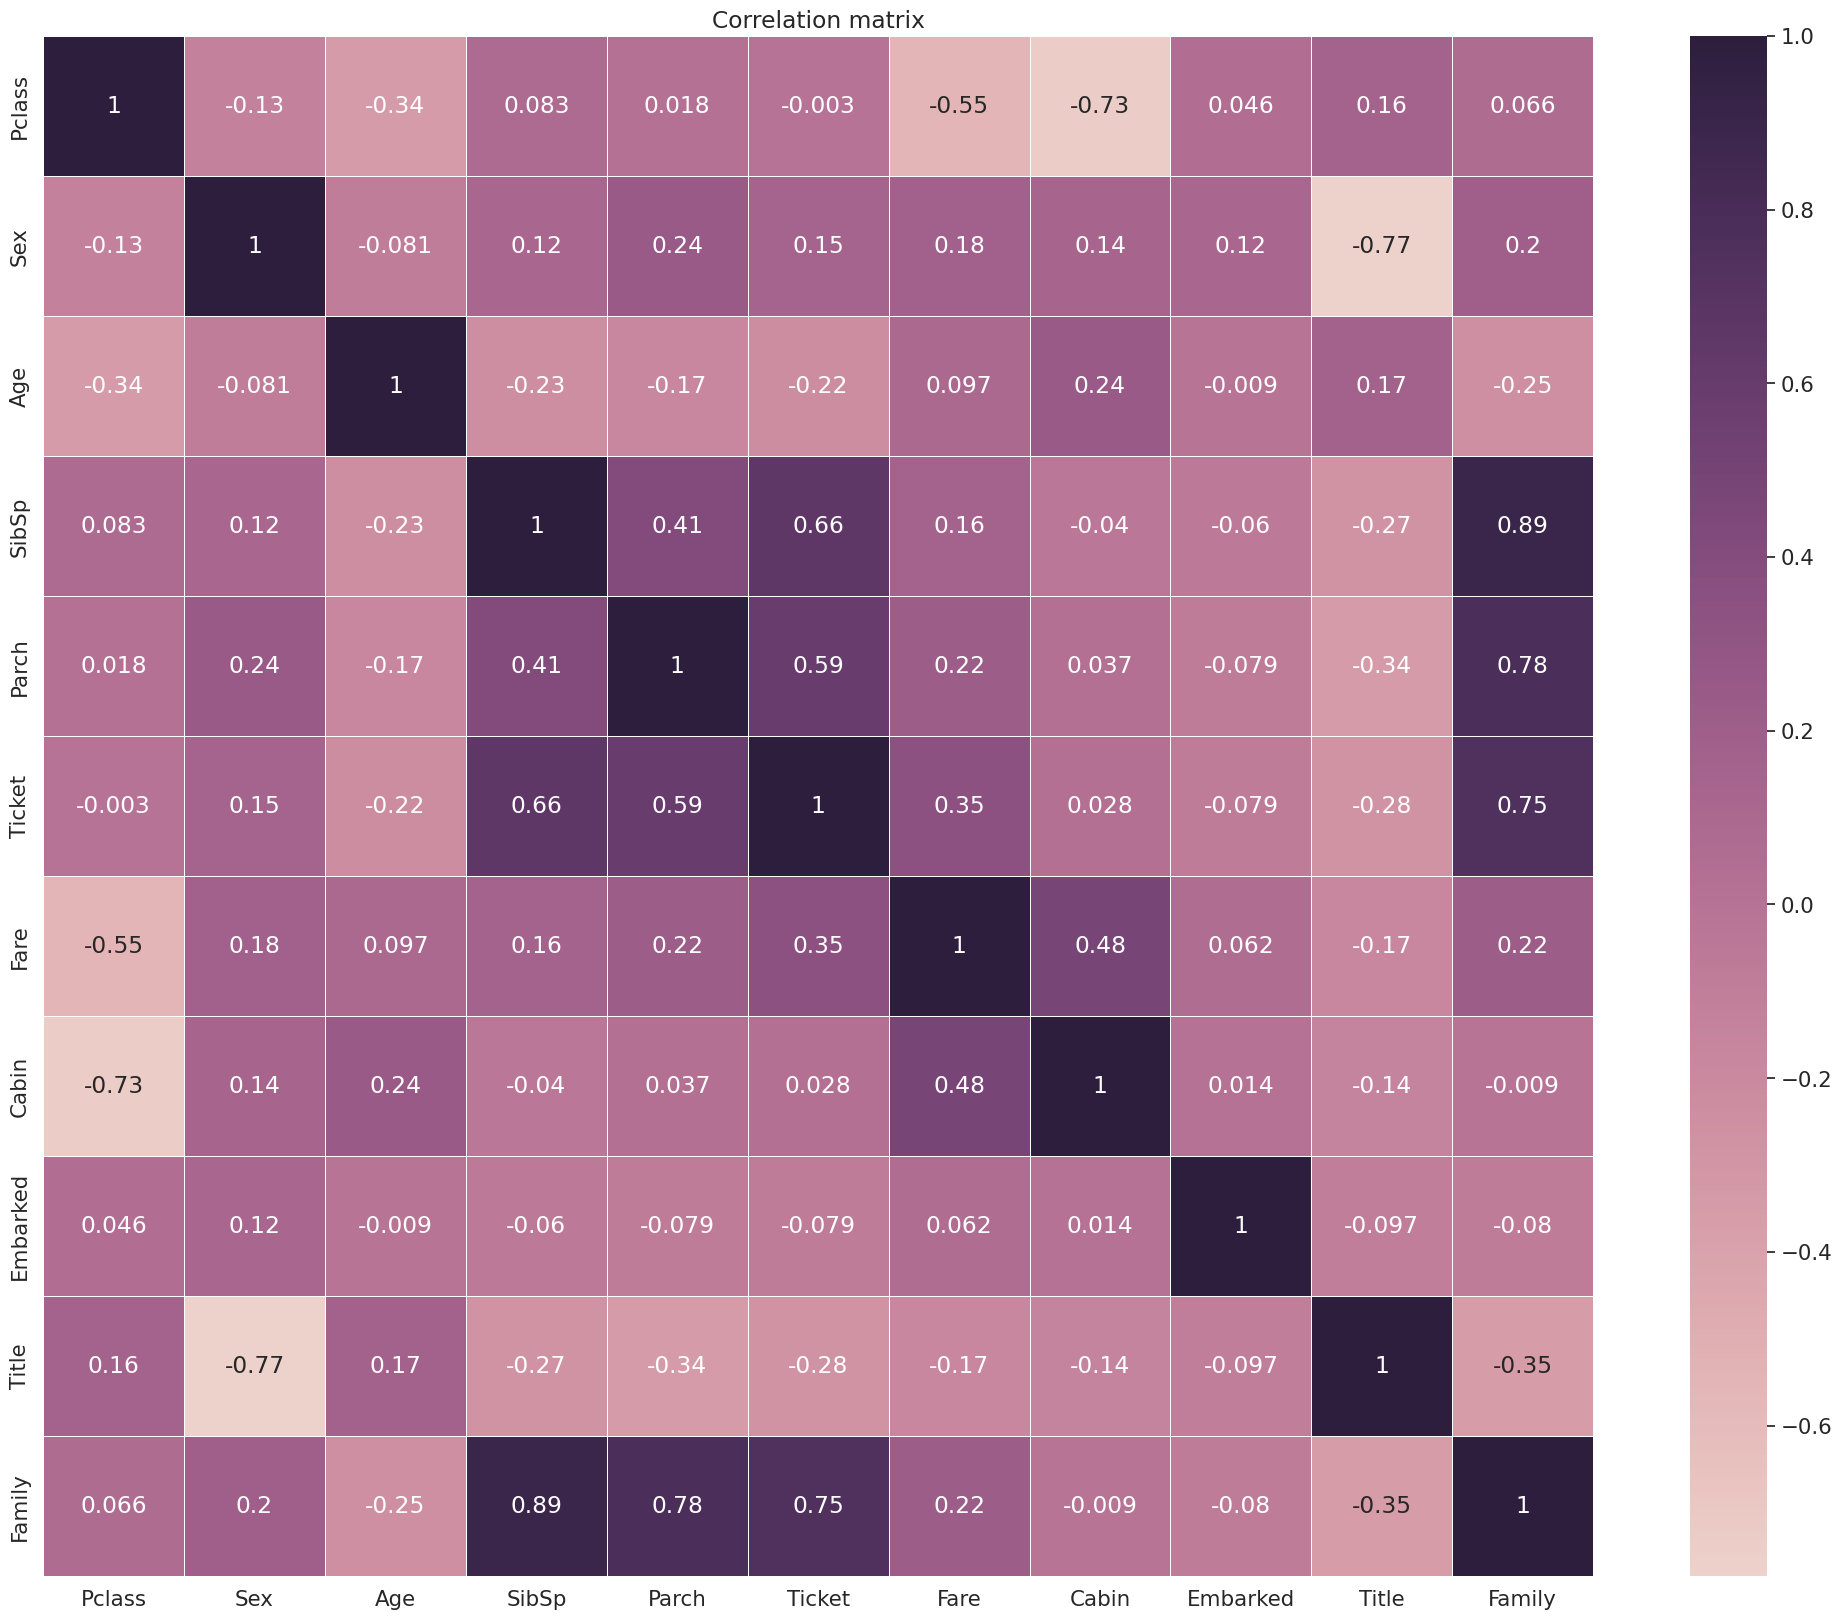

In [41]:
plt.figure(figsize = (25, 20))

sns.set(font_scale=1.4)
sns.heatmap(titanic[features].corr().round(3), annot=True, linewidths=.5, 
            cmap=sns.cubehelix_palette(as_cmap=True))

plt.title('Correlation matrix')
plt.show()

### Нормализация данных

In [42]:
survived = titanic[target]
titanic = titanic.drop(target, axis=1)
titanic = normalize(titanic, features)
test = normalize(test, features)
titanic[target] = survived
test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1.0,0.0,0.452723,0.000,0.000000,0.0,0.015282,0.0,1.0,1.000000,0.0
1,1.0,1.0,0.617566,0.125,0.000000,0.0,0.013663,0.0,0.0,0.297071,0.1
2,0.5,0.0,0.815377,0.000,0.000000,0.0,0.018909,0.0,1.0,1.000000,0.0
3,1.0,0.0,0.353818,0.000,0.000000,0.0,0.016908,0.0,0.0,1.000000,0.0
4,1.0,1.0,0.287881,0.125,0.111111,0.0,0.023984,0.0,0.0,0.297071,0.2


In [43]:
titanic.describe()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.654321,0.352413,0.363679,0.065376,0.063599,0.131313,0.062858,0.228956,0.180696,0.689174,0.090460,0.383838
std,0.418036,0.477990,0.163605,0.137843,0.134343,0.226857,0.096995,0.420397,0.317837,0.372740,0.161346,0.486592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.271174,0.000000,0.000000,0.000000,0.015440,0.000000,0.000000,0.350775,0.000000,0.000000
50%,1.000000,0.000000,0.346569,0.000000,0.000000,0.000000,0.028213,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.434531,0.125000,0.000000,0.166667,0.060508,0.000000,0.500000,1.000000,0.100000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Разбиение на train и test

In [44]:
x = titanic[features]
y = titanic[target]

x_tr, x_test, y_tr, y_test = train_test_split(x, y, shuffle=True, test_size=.3, random_state=42)

### Построение и оценка базовых моделей

**Логистическая регрессия**

In [45]:
lr = LogisticRegression()
lr.fit(x_tr, y_tr)

y_train_lr = lr.predict(x_tr)
y_test_lr = lr.predict(x_test)

get_classification_report(y_tr, y_train_lr, y_test, y_test_lr)

TRAIN
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       392
           1       0.79      0.72      0.75       231

    accuracy                           0.83       623
   macro avg       0.82      0.80      0.81       623
weighted avg       0.82      0.83      0.82       623

TEST
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       157
           1       0.77      0.76      0.76       111

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         132  25
1          27  84


**Персептрон**

In [46]:
percept = Perceptron(max_iter=5, tol=None)
percept.fit(x_tr, y_tr)

y_train_percept = percept.predict(x_tr)
y_test_percept = percept.predict(x_test)

get_classification_report(y_tr, y_train_percept, y_test, y_test_percept)

TRAIN
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       392
           1       0.78      0.70      0.74       231

    accuracy                           0.82       623
   macro avg       0.81      0.79      0.80       623
weighted avg       0.81      0.82      0.81       623

TEST
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       157
           1       0.78      0.75      0.76       111

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         133  24
1          28  83


**k ближайших соседей**

In [47]:
knn = KNeighborsClassifier()
knn.fit(x_tr, y_tr)

y_train_knn = knn.predict(x_tr)
y_test_knn = knn.predict(x_test)

get_classification_report(y_tr, y_train_knn, y_test, y_test_knn)

TRAIN
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       392
           1       0.87      0.77      0.82       231

    accuracy                           0.87       623
   macro avg       0.87      0.85      0.86       623
weighted avg       0.87      0.87      0.87       623

TEST
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       157
           1       0.84      0.68      0.75       111

    accuracy                           0.81       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.81      0.81       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         142  15
1          35  76


**Метод опорных векторов**

In [48]:
svc = SVC()
svc.fit(x_tr, y_tr)

y_train_svc = svc.predict(x_tr)
y_test_svc = svc.predict(x_test)

get_classification_report(y_tr, y_train_svc, y_test, y_test_svc)

TRAIN
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       392
           1       0.90      0.68      0.78       231

    accuracy                           0.85       623
   macro avg       0.87      0.82      0.83       623
weighted avg       0.86      0.85      0.85       623

TEST
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       157
           1       0.85      0.69      0.76       111

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         143  14
1          34  77


**LinearSVC**

In [49]:
lsvc = LinearSVC()
lsvc.fit(x_tr, y_tr)

y_train_lsvc = lsvc.predict(x_tr)
y_test_lsvc = lsvc.predict(x_test)

get_classification_report(y_tr, y_train_lsvc, y_test, y_test_lsvc)

TRAIN
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       392
           1       0.77      0.72      0.75       231

    accuracy                           0.82       623
   macro avg       0.81      0.80      0.80       623
weighted avg       0.82      0.82      0.82       623

TEST
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       157
           1       0.77      0.75      0.76       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.80      0.80      0.80       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         132  25
1          28  83


**Случайный лес**

In [50]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(x_tr, y_tr)

y_train_forest = forest.predict(x_tr)
y_test_forest = forest.predict(x_test)

get_classification_report(y_tr, y_train_forest, y_test, y_test_forest)

TRAIN
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       392
           1       0.99      0.97      0.98       231

    accuracy                           0.98       623
   macro avg       0.98      0.98      0.98       623
weighted avg       0.98      0.98      0.98       623

TEST
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       157
           1       0.76      0.70      0.73       111

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.78       268
weighted avg       0.79      0.79      0.79       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         133  24
1          33  78


**AdaBoost**

In [51]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(x_tr, y_tr)

y_train_ada = ada.predict(x_tr)
y_test_ada = ada.predict(x_test)

get_classification_report(y_tr, y_train_ada, y_test, y_test_ada)

TRAIN
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       392
           1       0.86      0.80      0.83       231

    accuracy                           0.88       623
   macro avg       0.87      0.86      0.87       623
weighted avg       0.88      0.88      0.88       623

TEST
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       157
           1       0.76      0.73      0.75       111

    accuracy                           0.79       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.79      0.79      0.79       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         132  25
1          30  81


**Наивный байесовский метод**

In [52]:
bayes = GaussianNB()
bayes.fit(x_tr, y_tr)

y_train_bayes = bayes.predict(x_tr)
y_test_bayes = bayes.predict(x_test)

get_classification_report(y_tr, y_train_bayes, y_test, y_test_bayes)

TRAIN
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       392
           1       0.67      0.80      0.73       231

    accuracy                           0.78       623
   macro avg       0.77      0.79      0.77       623
weighted avg       0.80      0.78      0.78       623

TEST
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       157
           1       0.72      0.86      0.78       111

    accuracy                           0.80       268
   macro avg       0.80      0.81      0.80       268
weighted avg       0.81      0.80      0.80       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         120  37
1          16  95


**XGBoost**

In [53]:
xgboost = xgb.XGBClassifier(random_state=42)
xgboost.fit(x_tr, y_tr)

y_train_xgb = xgboost.predict(x_tr)
y_test_xgb = xgboost.predict(x_test)

get_classification_report(y_tr, y_train_xgb, y_test, y_test_xgb)

TRAIN
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       392
           1       0.99      0.94      0.97       231

    accuracy                           0.98       623
   macro avg       0.98      0.97      0.97       623
weighted avg       0.98      0.98      0.98       623

TEST
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       157
           1       0.79      0.67      0.72       111

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.77       268
weighted avg       0.79      0.79      0.78       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         137  20
1          37  74


**LightGBM**

In [54]:
lightgbm = lgbm.LGBMClassifier(random_state=42)
lightgbm.fit(x_tr, y_tr)

y_train_lgbm = lightgbm.predict(x_tr)
y_test_lgbm = lightgbm.predict(x_test)

get_classification_report(y_tr, y_train_lgbm, y_test, y_test_lgbm)

TRAIN
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       392
           1       0.98      0.92      0.95       231

    accuracy                           0.96       623
   macro avg       0.97      0.95      0.96       623
weighted avg       0.96      0.96      0.96       623

TEST
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       157
           1       0.77      0.71      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.79       268
weighted avg       0.79      0.79      0.79       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         134  23
1          32  79


**CatBoost**

In [55]:
catboost = catb.CatBoostClassifier(silent=True, random_state=42)
catboost.fit(x_tr, y_tr)

y_train_catb = catboost.predict(x_tr)
y_test_catb = catboost.predict(x_test)

get_classification_report(y_tr, y_train_catb, y_test, y_test_catb)

TRAIN
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       392
           1       0.94      0.81      0.87       231

    accuracy                           0.91       623
   macro avg       0.92      0.89      0.90       623
weighted avg       0.91      0.91      0.91       623

TEST
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       157
           1       0.81      0.71      0.76       111

    accuracy                           0.81       268
   macro avg       0.81      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         139  18
1          32  79


### Выбор лучшей модели и подбор гиперпараметров

Самые лучшие результаты показал метод опорных векторов (Support Vector Classifier, SVC). Подберем наилучшие гиперпараметры для этой модели.

In [56]:
%time
params = {'C': [.1, 1, 10, 100], 
          'gamma': [1, .1, .01, .001], 
          'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(), params, refit=True, verbose=2)
grid.fit(x_tr, y_tr)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sig

[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=1, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ......................C=1, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END .....................C=100, gamma=0.01, kernel=poly; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ....................C=100, gamma=0.001, kernel=poly; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [57]:
grid.best_estimator_

SVC(C=1, gamma=1)

In [58]:
grid.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [59]:
grid.best_score_

0.8330709677419355

**Обучение и оценка финальной модели**

In [60]:
# Создаем модель с найденными нами наилучшими параметрами.
final = SVC(C=1, gamma=1, kernel='rbf')
final.fit(x_tr, y_tr)

y_train_final = final.predict(x_tr)
y_test_final = final.predict(x_test)

get_classification_report(y_tr, y_train_final, y_test, y_test_final)

TRAIN
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       392
           1       0.90      0.67      0.76       231

    accuracy                           0.85       623
   macro avg       0.86      0.81      0.83       623
weighted avg       0.85      0.85      0.84       623

TEST
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       157
           1       0.85      0.69      0.76       111

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268

CONFUSION MATRIX

col_0       0   1
Survived         
0         143  14
1          34  77


**Предсказание на тестовых данных**

In [61]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
0,1.0,0.0,0.452723,0.000,0.000000,0.0,0.015282,0.0,1.0,1.000000,0.0
1,1.0,1.0,0.617566,0.125,0.000000,0.0,0.013663,0.0,0.0,0.297071,0.1
2,0.5,0.0,0.815377,0.000,0.000000,0.0,0.018909,0.0,1.0,1.000000,0.0
3,1.0,0.0,0.353818,0.000,0.000000,0.0,0.016908,0.0,0.0,1.000000,0.0
4,1.0,1.0,0.287881,0.125,0.111111,0.0,0.023984,0.0,0.0,0.297071,0.2


In [62]:
test.describe()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.632775,0.363636,0.388096,0.055921,0.043594,0.087321,0.069441,0.217703,0.232057,0.689696,0.083971
std,0.420919,0.481622,0.167530,0.112095,0.109048,0.189267,0.109012,0.413179,0.342758,0.365683,0.151907
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.301068,0.000000,0.000000,0.000000,0.015412,0.000000,0.000000,0.322176,0.000000
50%,1.000000,0.000000,0.353818,0.000000,0.000000,0.000000,0.028213,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,0.469207,0.125000,0.000000,0.000000,0.061429,0.000000,0.500000,1.000000,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
# Просим модель создать нам предсказание для тестовой выборки.
survived = final.predict(test)

In [64]:
# Создаем датафрейм, в который записываем айди пассажиров, сохраненные нами в начале работы и 
# предсказание.
res_df = pd.DataFrame({'PassengerID': pass_id, 'Survived': survived})
res_df

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [65]:
# Видим, что опять выжила примерно одна треть пассажиров(
res_df['Survived'].value_counts()

0    286
1    132
Name: Survived, dtype: int64

In [66]:
# Запишем получившийся датафрейм в отдельный файл.
res_df.to_csv(RESULT_PATH, index=False)